In [12]:
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from scipy.fft import fft, ifft

from src.nn_datasets.components.eegdataset import (
    butter_bandpass_filter,
    load_eeg_data,
    butter_lowpass_filter,
    butter_highpass_filter,
)

from src.settings import TARGET_COLS

In [13]:
from src.utils.plot_batches import plot_zoomed_batch, plot_batch
from src.utils.custom import get_comp_score

In [17]:
df1 = pl.read_csv("logs/train/val_outputs/levit_128/val_preds.csv")

df2 = pl.read_csv("logs/train/val_outputs/pseudo_log_resv2/val_preds.csv")

df3 = pl.read_csv("logs/train/val_outputs/pseudo_log_v2/val_preds.csv")

print(get_comp_score(df1.filter(pl.col("num_votes") > 0)))
print(get_comp_score(df2.filter(pl.col("num_votes") > 0)))
print(get_comp_score(df3.filter(pl.col("num_votes") > 0)))


0.4984632342257026
0.5065753827316128
0.48572786674219537


In [18]:
for col in TARGET_COLS:
    mean_preds = (
        df1[f"{col}_pred"].to_numpy() * 0.5 + df2[f"{col}_pred"].to_numpy() * 0.5
    )
    df1 = df1.with_columns([pl.Series(f"{col}_pred", mean_preds)])
print(get_comp_score(df1.filter(pl.col("num_votes") > 0)))

0.47801898347168675


In [117]:
df = pl.read_csv("./data/train.csv")

In [118]:
df.head()

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


In [119]:
df = df.with_columns(
    (
        pl.col("eeg_id").cast(pl.String) + "_" + pl.col("eeg_sub_id").cast(pl.String)
    ).alias("unq_id")
)

In [120]:
unq_ids = df["unq_id"].unique().to_numpy()
len(unq_ids)

106800

In [121]:
unq_ids[0]

'2646491696_0'

In [122]:
eeg_data = load_eeg_data(unq_ids[0])
eeg_data.shape

TypeError: load_eeg_data() missing 2 required positional arguments: 'eeg_id' and 'eeg_sub_id'

In [79]:
def norm_target_cols(df):
    norm_targets = df.select(TARGET_COLS).to_numpy()
    target_sums = norm_targets.sum(axis=1, keepdims=True)
    norm_targets = norm_targets / target_sums
    return df.with_columns(
        *[pl.Series(target, norm_targets[:, i]) for i, target in enumerate(TARGET_COLS)]
    ).with_columns(pl.Series("num_votes", target_sums.flatten()))


df = pl.read_csv("./data/train.csv")
df = df.with_columns(
    (pl.sum_horizontal(TARGET_COLS)).alias("total_votes"),
)

df = norm_target_cols(df)

In [80]:
df_agg = df.group_by("eeg_id").agg(*[pl.col(col).mean() for col in TARGET_COLS])
df_agg[TARGET_COLS].mean()

seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
f64,f64,f64,f64,f64,f64
0.157227,0.141989,0.103554,0.064757,0.114483,0.41799


In [81]:
df_agg = df.group_by("patient_id").agg(*[pl.col(col).mean() for col in TARGET_COLS])
df_agg[TARGET_COLS].mean()

seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
f64,f64,f64,f64,f64,f64
0.34483,0.039809,0.047374,0.081013,0.234644,0.252329


In [104]:
df_agg = (
    df.filter(pl.col("num_votes") >= 1)
    .group_by("eeg_id")
    .agg(*[pl.col(col).mean() for col in TARGET_COLS])
)
df_agg[TARGET_COLS].mean()

seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
f64,f64,f64,f64,f64,f64
0.157227,0.141989,0.103554,0.064757,0.114483,0.41799


In [97]:
df_agg = (
    df.filter(pl.col("num_votes") > 1)
    .group_by("patient_id")
    .agg(*[pl.col(col).mean() for col in TARGET_COLS])
)
df_agg[TARGET_COLS].mean()

seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
f64,f64,f64,f64,f64,f64
0.345581,0.039966,0.047448,0.081474,0.235069,0.250462


In [3]:
np.flip(np.arange(1, 10)).double()

AttributeError: 'numpy.ndarray' object has no attribute 'double'

In [ ]:
from sklearn.utils import check_random_state
def _new_random_fft_phase_odd(c, n, random_state):
    rng = check_random_state(random_state)
    random_phase = 2j * np.pi * rng.random((c, (n - 1) // 2))
    return np.concatenate([
        np.zeros((c, 1)),
        random_phase,
        -np.flip(random_phase, [-1])
    ], dim=-1)

def _new_random_fft_phase_even(c, n, random_state):
    rng = check_random_state(random_state)
    random_phase = 2j * np.pi * rng.random((c, n  // 2 - 1))
    return np.concatenate([
        np.zeros((c, 1)),
        random_phase,
        np.zeros((c, 1)),
        -np.flip(random_phase, [-1])
    ], dim=-1)


_new_random_fft_phase = {
    0: _new_random_fft_phase_even,
    1: _new_random_fft_phase_odd
}

def ft_surrogate(
    X,
    y,
    phase_noise_magnitude,
    channel_indep=False,
    random_state=None
):
    """FT surrogate augmentation of a single EEG channel, as proposed in [1]_.

    Function copied from https://github.com/cliffordlab/sleep-convolutions-tf
    and modified.

    Parameters
    ----------
    X : torch.Tensor
        EEG input example or batch.
    y : torch.Tensor
        EEG labels for the example or batch.
    phase_noise_magnitude: float
        Float between 0 and 1 setting the range over which the phase
        perturbation is uniformly sampled:
        [0, `phase_noise_magnitude` * 2 * `pi`].
    channel_indep : bool
        Whether to sample phase perturbations independently for each channel or
        not. It is advised to set it to False when spatial information is
        important for the task, like in BCI.
    random_state: int | numpy.random.Generator, optional
        Used to draw the phase perturbation. Defaults to None.

    Returns
    -------
    torch.Tensor
        Transformed inputs.
    torch.Tensor
        Transformed labels.

    References
    ----------
    .. [1] Schwabedal, J. T., Snyder, J. C., Cakmak, A., Nemati, S., &
       Clifford, G. D. (2018). Addressing Class Imbalance in Classification
       Problems of Noisy Signals by using Fourier Transform Surrogates. arXiv
       preprint arXiv:1806.08675.
    """

    f = fft(X, dim=-1)

    n = f.shape[-1]
    random_phase = _new_random_fft_phase[n % 2](
        f.shape[-2] if channel_indep else 1,
        n,
        random_state=random_state
    )
    if not channel_indep:
        random_phase = np.tile(random_phase, (f.shape[0], 1))
    f_shifted = f * np.exp(phase_noise_magnitude * random_phase)
    shifted = ifft(f_shifted, dim=-1)
    transformed_X = shifted
    return transformed_X, y 

In [101]:
from src.utils.custom import get_comp_score, correct_means
from src.settings import TARGET_COLS
import polars as pl

val_df = pl.read_csv("./val_preds.csv")
val_df

eeg_id,eeg_sub_id,num_votes,seizure_vote_pred,seizure_vote_true,lpd_vote_pred,lpd_vote_true,gpd_vote_pred,gpd_vote_true,lrda_vote_pred,lrda_vote_true,grda_vote_pred,grda_vote_true,other_vote_pred,other_vote_true
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1628180742,0,3.0,0.5626566,1.0,0.026035,0.0,0.000843,0.0,0.100033,0.0,0.009853,0.0,0.300581,0.0
1628180742,1,3.0,0.652696,1.0,0.024625,0.0,0.000801,0.0,0.072961,0.0,0.007629,0.0,0.2412888,0.0
1628180742,2,3.0,0.6426319,1.0,0.022033,0.0,0.000714,0.0,0.076819,0.0,0.007614,0.0,0.250188,0.0
1628180742,3,3.0,0.667535,1.0,0.015915,0.0,0.000598,0.0,0.063412,0.0,0.007925,0.0,0.244615,0.0
1628180742,4,3.0,0.680862,1.0,0.017638,0.0,0.000759,0.0,0.04883,0.0,0.005078,0.0,0.2468328,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
351917269,6,3.0,0.004755,0.0,0.005051,0.0,0.000725,0.0,0.296756,1.0,0.5285084,0.0,0.164205,0.0
351917269,7,3.0,0.008437,0.0,0.006616,0.0,0.000927,0.0,0.325695,1.0,0.500521,0.0,0.157804,0.0
351917269,8,3.0,0.006241,0.0,0.007484,0.0,0.001089,0.0,0.329284,1.0,0.504556,0.0,0.1513472,0.0


In [102]:
get_comp_score(val_df)

       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  3719336260      0.005304  0.003271  ...   0.009290   0.007612    0.971048
1   261945270      0.000599  0.000399  ...   0.019993   0.538667    0.438790
2  2712678256      0.002244  0.000275  ...   0.018553   0.776508    0.200202
3  2191916085      0.216683  0.004713  ...   0.000629   0.000670    0.750375
4  4119832864      0.004930  0.004437  ...   0.142682   0.565422    0.282099

[5 rows x 7 columns]
       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  3719336260      0.000000       0.0  ...        0.0        0.0    1.000000
1   261945270      0.000000       0.0  ...        0.0        0.5    0.500000
2  2712678256      0.000000       0.0  ...        0.0        1.0    0.000000
3  2191916085      0.055556       0.0  ...        0.0        0.0    0.944444
4  4119832864      0.000000       0.0  ...        0.5        0.0    0.500000

[5 rows x 7 columns]


0.4789247714495602

In [103]:
pred_cols = [f"{col}_pred" for col in TARGET_COLS]
true_cols = [f"{col}_true" for col in TARGET_COLS]

In [104]:
val_df = val_df.group_by("eeg_id").agg(
    *[pl.col(f"{col}_pred").mean().alias(f"{col}_pred") for col in TARGET_COLS],
    *[pl.col(f"{col}_true").mean().alias(f"{col}_true") for col in TARGET_COLS],
    pl.col("num_votes").mean(),
)

In [105]:
get_comp_score(val_df)

       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  3096691694      0.000649  0.006123  ...   0.005906   0.111759    0.865428
1  1573271676      0.066347  0.078553  ...   0.000743   0.004282    0.065612
2  1112997516      0.008513  0.006566  ...   0.007543   0.022639    0.950958
3  2036186052      0.003605  0.000659  ...   0.020421   0.416632    0.554108
4  3186238938      0.009874  0.000615  ...   0.022684   0.107192    0.858920

[5 rows x 7 columns]
       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  3096691694           0.0     0.000  ...        0.0   0.333333    0.666667
1  1573271676           0.0     0.375  ...        0.0   0.000000    0.000000
2  1112997516           0.0     0.000  ...        0.0   0.000000    1.000000
3  2036186052           0.0     0.000  ...        0.0   0.000000    1.000000
4  3186238938           0.0     0.000  ...        0.0   0.000000    1.000000

[5 rows x 7 columns]


0.4789247714495602

In [106]:
val_df = val_df.filter(pl.col("num_votes") > 7)

In [107]:
val_df.select(*pred_cols).mean()

seizure_vote_pred,lpd_vote_pred,gpd_vote_pred,lrda_vote_pred,grda_vote_pred,other_vote_pred
f64,f64,f64,f64,f64,f64
0.069455,0.129132,0.105628,0.080103,0.106062,0.509622


In [108]:
val_df.select(*true_cols).mean()

seizure_vote_true,lpd_vote_true,gpd_vote_true,lrda_vote_true,grda_vote_true,other_vote_true
f64,f64,f64,f64,f64,f64
0.0377,0.151695,0.124666,0.07252,0.086362,0.527056


In [109]:
get_comp_score(val_df)

       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  2504511222      0.010242  0.023003  ...   0.032214   0.288701    0.557266
1  3286203761      0.001968  0.315417  ...   0.018675   0.005353    0.655371
2  2650934706      0.000572  0.016405  ...   0.001841   0.000673    0.980244
3  2421124746      0.005607  0.046052  ...   0.020902   0.026760    0.897946
4  2196707180      0.011348  0.866295  ...   0.002316   0.001440    0.034366

[5 rows x 7 columns]
       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0  2504511222      0.000000  0.076923  ...   0.153846   0.153846    0.461538
1  3286203761      0.000000  0.857143  ...   0.071429   0.000000    0.071429
2  2650934706      0.000000  0.000000  ...   0.000000   0.000000    1.000000
3  2421124746      0.000000  0.000000  ...   0.066667   0.000000    0.933333
4  2196707180      0.071429  0.928571  ...   0.000000   0.000000    0.000000

[5 rows x 7 columns]


0.29703924113724667

In [113]:
from src.utils.custom import norm_preds
import numpy as np


def rev_sigmoid(y):
    return np.log(y / (1 - y))


def correct_means(y, target_means):
    # y = np.clip(y, 1e-12, 1 - 1e-12)
    # yhat = rev_sigmoid(y)
    # means = y.mean(axis=0)

    # target_means = rev_sigmoid(target_means)
    # target_means = target_means.reshape(1, -1)
    # means = rev_sigmoid(means).reshape(1, -1)
    # yhat = yhat / means * target_means
    # yhat = 1 / (1 + np.exp(-yhat))
    # yhat = np.mean([y, yhat], axis=0)
    y = y / y.mean(axis=0, keepdims=True) * target_means
    return y


preds = val_df.select(*pred_cols).to_numpy()
preds = correct_means(
    preds, target_means=val_df.select(*true_cols).to_numpy().mean(axis=0)
)
preds = norm_preds(preds)
preds.mean(0)

array([0.049191  , 0.14679163, 0.12054002, 0.07639672, 0.09334666,
       0.51373396])

In [114]:
val_df = val_df.with_columns(
    *[pl.Series(col, preds[:, i]) for i, col in enumerate(pred_cols)]
)
get_comp_score(val_df)

       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0   366322771      0.007273  0.001990  ...   0.007742   0.029233    0.946264
1  2250860233      0.011437  0.494525  ...   0.036645   0.002643    0.453193
2   377461803      0.000707  0.237931  ...   0.111080   0.003190    0.645862
3  3789021618      0.002428  0.164816  ...   0.051980   0.129772    0.559930
4  2638864661      0.036798  0.025604  ...   0.587789   0.123533    0.222798

[5 rows x 7 columns]
       eeg_id  seizure_vote  lpd_vote  ...  lrda_vote  grda_vote  other_vote
0   366322771           0.0  0.000000  ...   0.000000   0.000000    1.000000
1  2250860233           0.0  0.666667  ...   0.000000   0.000000    0.333333
2   377461803           0.0  0.461538  ...   0.153846   0.000000    0.384615
3  3789021618           0.0  0.214286  ...   0.000000   0.071429    0.714286
4  2638864661           0.0  0.000000  ...   0.142857   0.071429    0.785714

[5 rows x 7 columns]


0.29490887449034703

In [56]:
unq_id = np.random.choice(unq_ids, 1)[0]
print(unq_id)
targets = df.filter(pl.col("unq_id") == unq_id).select(TARGET_COLS).to_numpy()
print(df.filter(pl.col("unq_id") == unq_id).select(TARGET_COLS))
data = np.load(f"./data/train_eegs/{unq_id}.npy")

158208938_35
shape: (1, 6)
┌──────────────┬──────────┬──────────┬───────────┬───────────┬────────────┐
│ seizure_vote ┆ lpd_vote ┆ gpd_vote ┆ lrda_vote ┆ grda_vote ┆ other_vote │
│ ---          ┆ ---      ┆ ---      ┆ ---       ┆ ---       ┆ ---        │
│ i64          ┆ i64      ┆ i64      ┆ i64       ┆ i64       ┆ i64        │
╞══════════════╪══════════╪══════════╪═══════════╪═══════════╪════════════╡
│ 0            ┆ 0        ┆ 4        ┆ 0         ┆ 0         ┆ 2          │
└──────────────┴──────────┴──────────┴───────────┴───────────┴────────────┘


In [60]:
y = np.random.rand(10)
y

array([0.01121283, 0.89443939, 0.04074011, 0.72896896, 0.54773241,
       0.57164971, 0.91313747, 0.9362867 , 0.58172192, 0.13851973])

In [63]:
y.mean()

0.5364409231334817

In [68]:
def correct_means(y, target_means):
    yhat = np.log(y / (1 - y))
    target_means = np.log(target_means / (1 - target_means))
    target_means = target_means.reshape(1, -1)
    yhat = yhat / yhat.mean(keepdims=True, axis=0) * target_means
    yhat = 1 / (1 + np.exp(-yhat))
    return yhat

In [71]:
y = np.random.rand(10, 5)
means = np.array([0.5, 0.5, 0.52, 0.48, 0.5])
yhat = correct_means(y, means)
yhat.mean(axis=0)

array([0.5       , 0.5       , 0.51992671, 0.48023424, 0.5       ])

In [66]:
yhat = np.log(y / (1 - y))
new_mean = 0.5
new_mean_yhat = np.log(new_mean / (1 - new_mean))
yhat = yhat / yhat.mean() * new_mean_yhat
yhat_sig = 1 / (1 + np.exp(-yhat))



In [67]:
yhat_sig.mean()

0.5

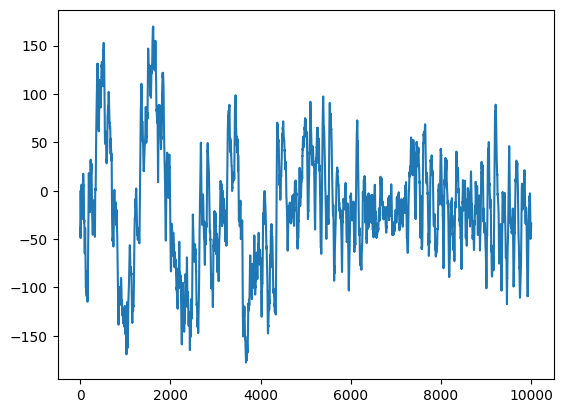

In [24]:
data = butter_lowpass_filter(data, 40, 200, order=5)
plt.plot(data[:, 0])

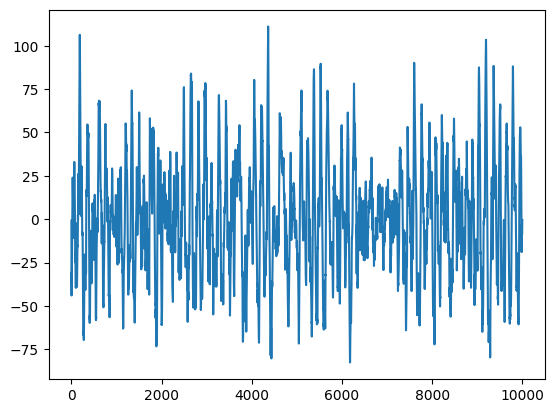

In [26]:
s11 = butter_highpass_filter(data, 0.5, 200, order=4)[:, 0]
plt.plot(s11)

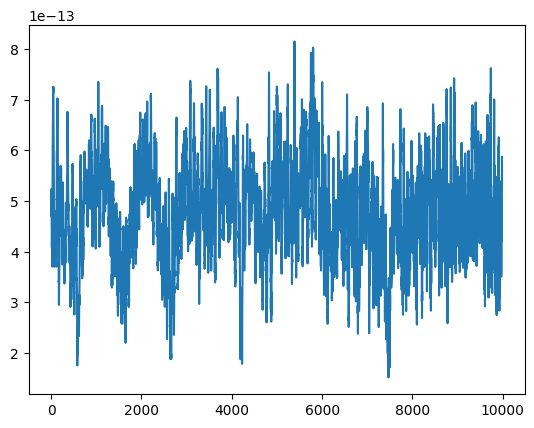

In [24]:
aa = load_eeg_data(Path("./data/train_eegs"), 1628180742, 0, 0.01, 20, 6)
plt.plot(aa[:, 0])

In [4]:
df_wave = pd.read_parquet(f"./data/train_eegs/{df['eeg_id'].iloc[0]}.parquet")
df_wave

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-144.660004,-147.809998,-129.820007,-129.460007,-157.509995,-124.000000,-124.570000,-94.820000,-153.070007,-121.110001,-86.459999,-132.520004,-138.339996,-128.970001,-71.300003,-114.480003,-86.709999,-114.959999,-81.500000,-20.070000
17996,-140.880005,-153.000000,-129.529999,-129.020004,-154.059998,-131.220001,-128.380005,-95.000000,-140.820007,-114.639999,-84.379997,-115.339996,-119.230003,-114.709999,-70.989998,-92.129997,-79.639999,-116.139999,-81.879997,10.600000
17997,-133.729996,-141.770004,-121.900002,-122.370003,-158.750000,-123.550003,-127.730003,-93.089996,-125.230003,-106.489998,-83.419998,-112.720001,-103.209999,-107.629997,-61.869999,-97.910004,-77.150002,-106.500000,-75.339996,-2.060000
17998,-141.449997,-151.139999,-127.190002,-128.699997,-163.460007,-124.309998,-129.479996,-94.419998,-140.869995,-113.339996,-83.519997,-129.300003,-118.650002,-117.589996,-71.879997,-99.279999,-83.900002,-116.160004,-81.410004,2.820000


In [5]:
df_wave.columns

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'],
      dtype='object')

In [6]:
df_wave.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997


In [3]:
import polars as pl
from pathlib import Path
from src.nn_datasets.eegdataset import HMSTrainEEGDataV2, HMSValEEGData
from src.nn_augs.eeg_transforms import *

In [4]:
tr_df = pl.read_csv("./data/train.csv")

In [5]:
tfm = [SideSwap(1.0)]

In [6]:
tr_ds = HMSTrainEEGDataV2(tr_df, Path("./data/train_eegs"))

In [64]:
tr_df.filter(pl.col("eeg_label_offset_seconds") > 2000)

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1641054670,461,2002.0,577118473,461,2002.0,2115422030,10187,"""GPD""",0,1,2,0,0,0
1641054670,462,2004.0,577118473,462,2004.0,1689948336,10187,"""GPD""",0,1,2,0,0,0
1641054670,463,2008.0,577118473,463,2008.0,3005581469,10187,"""GPD""",0,1,2,0,0,0
1641054670,464,2014.0,577118473,464,2014.0,3418274088,10187,"""GPD""",0,1,2,0,0,0
1641054670,465,2016.0,577118473,465,2016.0,508909142,10187,"""GPD""",0,1,2,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2428433259,659,3304.0,1974785580,831,4198.0,784773892,57378,"""GRDA""",0,0,0,0,13,2
2428433259,660,3306.0,1974785580,832,4200.0,1174747157,57378,"""GRDA""",0,0,0,0,13,2
2428433259,661,3310.0,1974785580,833,4204.0,258873760,57378,"""GRDA""",0,0,0,0,13,2


In [66]:
3314 * 200

662800

In [68]:
tmp = pl.read_parquet("./data/train_eegs/2428433259.parquet")

In [71]:
col_idx = {c: i for i, c in enumerate(tmp.columns)}
col_idx

{'Fp1': 0,
 'F3': 1,
 'C3': 2,
 'P3': 3,
 'F7': 4,
 'T3': 5,
 'T5': 6,
 'O1': 7,
 'Fz': 8,
 'Cz': 9,
 'Pz': 10,
 'Fp2': 11,
 'F4': 12,
 'C4': 13,
 'P4': 14,
 'F8': 15,
 'T4': 16,
 'T6': 17,
 'O2': 18,
 'EKG': 19}

In [58]:
import numpy as np

idx = np.random.choice(len(tr_ds))
print(idx)
np.mean(tr_ds[idx][0][:, 0]), tr_ds[idx][1]

1027


(-0.051505595, array([[1., 0., 0., 0., 0., 0.]]))

In [67]:
tr_ds[idx][0].shape

(10000, 20)

In [55]:
np.where(tr_ds[1814][0][500:, 0] < 10)

(array([2300, 2301, 2302, ..., 9497, 9498, 9499]),)

In [56]:
list(tr_ds[1814][0][2300:, 0])

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [3]:
tr_ds.df.filter(pl.col("sample_weight") > 10)

eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,patient_sample_count,eeg_sample_count,sample_weight,num_votes
i64,i64,f64,i64,i64,f64,i64,i64,str,f64,f64,f64,f64,f64,f64,u32,u32,f64,i64


In [4]:
vl_ds = HMSValEEGData(tr_df)
vl_ds[0]

(array([[ -80.52,  -70.54,  -80.11, ..., -121.73, -106.45,    7.92],
        [ -80.45,  -70.33,  -81.76, ..., -115.5 , -102.06,   29.22],
        [ -80.21,  -75.87,  -82.05, ..., -123.88, -105.79,   45.74],
        ...,
        [-149.62, -147.48, -171.96, ..., -116.42, -119.1 ,   95.59],
        [-126.86, -122.89, -125.88, ..., -110.03, -116.24,   72.98],
        [-131.34, -153.47, -168.32, ..., -108.33, -114.34,   25.55]],
       dtype=float32),
    seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
 0           1.0       0.0       0.0        0.0        0.0         0.0)

In [5]:
vl_ds.df["num_votes"].describe()

statistic,value
str,f64
"""count""",106800.0
"""null_count""",0.0
"""mean""",7.255496
"""std""",5.645681
"""min""",1.0
"""25%""",3.0
"""50%""",3.0
"""75%""",13.0
"""max""",28.0


In [6]:
from src.settings import TARGET_COLS

In [18]:
vl_ds.df.group_by(["num_votes", "eeg_id"]).agg(
    pl.col(TARGET_COLS[3]).mean().alias("mean"),
).group_by("num_votes").agg(
    pl.col("mean").mean().alias("mean"),
).sort(
    "num_votes"
).plot(
    "mean"
)

:Curve   [mean]   (num_votes)

In [19]:
from torch import nn
import lightning as L

In [20]:
class Conv1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(Conv1DBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class ConvRNNModel(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        rnn_hidden_size,
        rnn_num_layers,
        rnn_dropout,
        num_outputs=6,
    ):
        super(ConvRNNModel, self).__init__()
        self.conv1 = Conv1DBlock(
            in_channels, out_channels, kernel_size, stride, padding
        )
        self.rnn = nn.LSTM(
            out_channels,
            rnn_hidden_size,
            rnn_num_layers,
            dropout=rnn_dropout,
            batch_first=True,
        )
        self.fc = nn.Linear(rnn_hidden_size, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [33]:
import torch


class LitModel(L.LightningModule):
    def __init__(self, model, *args, **kwargs):
        super(LitModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.functional.kl_div(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-3)

In [34]:
from torch.utils.data import DataLoader

train_ds = HMSTrainEEGData(tr_df)
val_ds = HMSValEEGData(tr_df)

train_dl = DataLoader(train_ds, batch_size=32, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=4)

In [35]:
base_model = ConvRNNModel(19, 64, 3, 1, 1, 128, 2, 0.5)
model = LitModel(base_model)
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, train_dl, val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | ConvRNNModel | 236 K 
---------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.944     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]